# Assignment 2

For clarity I remade the notebook where I could better understand the initial code, please scroll down to find my methodology for completing the questions. I have titled each section to make this easier to navigate

In [152]:
!pip install pandas

In [153]:
!pip install matplotlib

In [154]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch

In [155]:
df = pd.read_csv("data/ml-latest-small/ratings.csv")

In [156]:
len(df)

100004

In [157]:
df.tail(100) #the last 100 films

,userId,movieId,rating,timestamp
99904,671,590,4.0,1065149296
99905,671,608,4.0,1064890575
99906,671,745,4.0,1065149085
99907,671,919,4.0,1065149458
99908,671,1035,5.0,1065149492
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [158]:
user_ids = df["userId"].unique().tolist() #this is your vocab for the embeddings
movie_ids = df["movieId"].unique().tolist()

In [159]:
#Make a dictionary mapping ids (keys) to indexes (values)
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}

In [160]:
#Make a new column in the dataframe which contains the appropriate index for each user and movie
df["user_index"] = [user_id_to_index[i] for i in df["userId"]]
df["movie_index"] = [movie_id_to_index[i] for i in df["movieId"]]

In [161]:
df.head(5)

,userId,movieId,rating,timestamp,user_index,movie_index
0,1,31,2.5,1260759144,0,0
1,1,1029,3.0,1260759179,0,1
2,1,1061,3.0,1260759182,0,2
3,1,1129,2.0,1260759185,0,3
4,1,1172,4.0,1260759205,0,4


In [162]:
df["rating"].describe()

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [163]:
!pip install sklearn

In [164]:
from sklearn.preprocessing import MinMaxScaler
##Pick the range\
df["rating"] = MinMaxScaler().fit_transform(df["rating"].values.reshape(-1, 1))

In [165]:
df["rating"].describe()

count    100004.000000
mean          0.676357
std           0.235125
min           0.000000
25%           0.555556
50%           0.777778
75%           0.777778
max           1.000000
Name: rating, dtype: float64

In [166]:
import sklearn

In [167]:
from sklearn.model_selection import train_test_split #splitting the data into trainting and test set 
#Inputs
x = df[["user_index", "movie_index"]]
#Outputs
y = df["rating"]
#Get train-test split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

In [168]:
import torch

In [169]:
#Define class and subclass torch.nn.Module
class LouisNet(torch.nn.Module):
    
    #Override __init__()
    def __init__(self):
        super().__init__()
        print("__init__ called")
    
    #Override forward()
    def forward(self, inputs):
        print("\nforwards pass (new batch)")
        print(inputs,"\n")
        #return the output (its just the input, unchanged)
        return inputs

#Make a new instance of LouisNet    
louisNet = LouisNet()
loss_fn = torch.nn.MSELoss() 

#Fake dataset
x = torch.FloatTensor([[1],[2],[3],[4]])
y = torch.FloatTensor([[2],[3],[4],[5]])

#Do a forwards pass
prediction = louisNet(x)
loss = loss_fn(prediction, y)

__init__ called

forwards pass (new batch)
tensor([[1.],
        [2.],
        [3.],
        [4.]]) 



In [170]:
class RecommenderNet(torch.nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=20):
        super().__init__()
        self.user_embedding = torch.nn.Embedding(num_users, embedding_size)
        self.user_bias = torch.nn.Embedding(num_users, 1)
        self.movie_embedding = torch.nn.Embedding(num_movies, embedding_size)
        self.movie_bias = torch.nn.Embedding(num_movies, 1)
        self.sig = torch.nn.Sigmoid()

    def forward(self, inputs):
        #Split out indexes 
        user_indexes = inputs[:, 0]
        movie_indexes = inputs[:, 1]
        #Forward pass on embedding layer
        user_vector = self.user_embedding(user_indexes)
        user_bias = self.user_bias(user_indexes).flatten()
        movie_vector = self.movie_embedding(movie_indexes)
        movie_bias = self.movie_bias(movie_indexes).flatten()
        #Dot product
        dot = (user_vector * movie_vector).sum(1)
        with_bias = dot + user_bias + movie_bias
        #Activation function
        output = self.sig(with_bias)
        return output

In [171]:
#Pick Embedding size
EMBEDDING_SIZE = 16
#Make new object (calls __init__())
num_users = len(user_ids)
num_movies = len(movie_ids)
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

In [172]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

#Make a subclass to hold our dataset (movie - user pairs (input) and a rating (label))
class MoviesDataset(Dataset):
    def __init__(self, X,y):
        self.X = torch.IntTensor(X)
        self.y = torch.FloatTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [173]:
#Use our train - validation split to make DataLoader objects
train_dl = DataLoader(MoviesDataset(x_train.values,y_train.values), batch_size=64, shuffle=True)
validation_dl = DataLoader(MoviesDataset(x_val.values,y_val.values), batch_size=64, shuffle=True)

In [174]:
epochs = 10
#Use Mean Squared Error as a loss function
loss_fn = torch.nn.MSELoss() 
#Use the Adam algorithm to update the weights based on the loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [175]:
#Use a for loop to repeat for the desired number of epochs 
for i in range(epochs):
    
    model.train(True)
    
    #Use a for loop for each batch (provided by the Dataloader)
    running_loss = 0.0
    for (index, batch) in enumerate(train_dl):
        
        #Get batch 
        inputs, labels = batch
        model.zero_grad()
        
        #Forward pass
        prediction = model(inputs)
        
        #Get Loss
        loss = loss_fn(prediction, labels)
        
        #Update weights (back prop)
        loss.backward()
        optimizer.step()
        running_loss += loss
    
    avg_loss = running_loss / (index + 1)

    model.train(False)

    #Now try with the validation set (no need to update weights, just get loss)
    running_vloss = 0.0
    for index, vdata in enumerate(validation_dl):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (index + 1)
    print('Loss {} Validation Loss {}'.format(avg_loss, avg_vloss))

Loss 0.17381133139133453 Validation Loss 0.11572198569774628
Loss 0.07822231948375702 Validation Loss 0.08147401362657547
Loss 0.04972934350371361 Validation Loss 0.07015117257833481
Loss 0.037913233041763306 Validation Loss 0.06549663841724396
Loss 0.03182947635650635 Validation Loss 0.06375189870595932
Loss 0.028082076460123062 Validation Loss 0.06346041709184647
Loss 0.025711392983794212 Validation Loss 0.06303949654102325
Loss 0.024111898615956306 Validation Loss 0.06227697432041168
Loss 0.022930093109607697 Validation Loss 0.06313871592283249
Loss 0.022129882127046585 Validation Loss 0.06361205875873566


In [176]:
torch.save(model.state_dict(), 'model_weights.pth')

In [177]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

RecommenderNet(
  (user_embedding): Embedding(671, 16)
  (user_bias): Embedding(671, 1)
  (movie_embedding): Embedding(9066, 16)
  (movie_bias): Embedding(9066, 1)
  (sig): Sigmoid()
)

In [178]:
num_users, EMBEDDING_SIZE, model.user_embedding

(671, 16, Embedding(671, 16))

# Tasks 1


We're going to ask you take the trained model and write the code to make two metrics - **Diversity** and **Novelty**. You should end up with **one statistic** for each that tells you something about the recommendations of the trained model based on the **whole dataset**.


#### Pro Tip

This will take quite a long time to run on the whole dataset, so start off by trying to get the code to work for **one user**, then expand to **two users**, then **every user**.

### Diversity 

This tells us what the mean diversity (inverse of the similarity, based on movie embeddings) between each film in every users Top 10 films is. 

1. Calculate every user's top 10


2. For each top 10, get the embedding for each film then use this to calculate the similarity matrix


3. Invert similarity to get the difference


4. Get mean difference for each top 10 


5. Report the mean for whole dataset (every top 10)


### Novelty 

This tells us what the mean popularity (e.g. mean rating) of the films in every users Top 10 films is 

1. Calculate every user's top 10


2. For each top 10, get the mean rating for each film (based on the original **MovieLens Small** dataset (``df = pd.read_csv("ml-latest-small/ratings.csv")``). 


3. Get the mean rating for each top 10.


4. Report the mean for the whole dataset (every top 10).

## Diversity

#### 1. Calculate every users top 10

In [254]:
movie_data = pd.read_csv("data/ml-latest-small/movies.csv")
movie_data.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [255]:
#max value in the movie index column
max(movie_data["movieId"])

164979

In [180]:
def get_top_n(user = 0, n = 10): 
    #Get Movie Names
    top_n_indexes = get_top_n_indexes(user, n)
    top_n = get_names_for_indexes(top_n_indexes)
    return top_n

def get_names_for_indexes(indexes):
    return [movie_data[movie_data["movieId"]==movie_ids[i]]["title"].item() for i in indexes]

def get_top_n_indexes(user = 0, n = 10):
    #For one user, make a pair with every movie index
    x = torch.IntTensor([[user, i] for i in np.arange(num_movies)])
    #Predict 
    predicted_ratings = model(x)
    #Get Top-N indexes
    top_n_indexes = predicted_ratings.argsort()[-10:]
    return top_n_indexes

In [181]:
get_top_n_indexes(user_ids[0]) #this works when I use one user but when I try to scale it up for more useres it returns an error

tensor([4880, 4830, 8240, 4888, 6186, 1870, 8630, 5420, 8251, 5120])

To calculate every users top ten I need to iterate through the get_top_n_indexes

In [182]:
x_list = []  #Getting the top 10 films for each user

for i, user in enumerate(user_ids):
    x = torch.Tensor(get_top_n_indexes(i))
    x_list.append(x)

In [183]:
x_list[0]

tensor([ 708, 5460, 3778, 3926, 2862, 1626, 9027, 8852, 2408, 7515])

In [184]:
#x_list = x_list[0] #this was used when I was just looking at one user

In [185]:
x_series = torch.stack(x_list) #turning the list into a tensor

In [186]:
x_series #making sure the tensor looks right

tensor([[ 708, 5460, 3778,  ..., 8852, 2408, 7515],
        [4880, 4830, 8240,  ..., 5420, 8251, 5120],
        [4996, 5626, 8377,  ..., 8102, 7803, 8318],
        ...,
        [7250, 8294, 6828,  ..., 7327, 8525, 7347],
        [5559, 8353, 5295,  ..., 9004, 5205, 2919],
        [7889, 8418, 7582,  ..., 1673, 4691, 8382]])

In [187]:
x_series.shape #checking the shape of the tensor

torch.Size([671, 10])

In [188]:
print('The movie: \n',model.movie_embedding)
print('The user: \n', model.user_embedding)

The movie: 
 Embedding(9066, 16)
The user: 
 Embedding(671, 16)


In [189]:
embeddings = model.movie_embedding(x_series) #getting the embedding's for the top 10 films for each user
print(embeddings[:1])
print(embeddings.shape)

tensor([[[-5.5748e-01, -9.7787e-01, -3.2814e+00,  6.8529e-01, -1.8273e+00,
           1.4541e-01, -1.2380e+00, -1.4101e+00,  6.3837e-01, -7.7418e-01,
           4.1331e-02, -1.7562e+00, -1.8961e+00, -1.7411e+00,  8.1404e-01,
           5.2566e-02],
         [-3.2253e-01,  1.2204e+00, -2.9107e+00,  6.2416e-02, -4.7467e-01,
           1.1003e+00, -1.4225e+00,  5.2200e-01, -7.7910e-01,  1.0930e+00,
           1.2270e+00,  4.8787e-01,  3.9485e-03,  1.1865e+00,  1.1778e+00,
          -8.8310e-02],
         [-8.5180e-01, -2.8252e-01, -7.0659e-01,  1.0494e+00, -1.8590e-01,
          -1.4612e+00, -9.2398e-01, -5.2881e-01, -1.1173e+00, -1.4643e+00,
           1.3027e+00, -1.0900e+00, -8.4696e-02, -1.2991e+00,  1.2612e+00,
           1.8565e+00],
         [ 1.7475e-01,  1.8404e+00, -3.9274e+00,  3.5143e+00, -5.9479e-01,
          -2.7686e-01, -1.0208e+00,  1.5919e+00,  1.0538e+00, -2.8000e+00,
           7.2638e-01,  7.9631e-01, -1.2426e+00,  8.4041e-01,  1.3434e+00,
           9.6983e-01],
    

In [190]:
#condensing the embeddings into a 2D array
embeddings = embeddings.reshape(671, 10*EMBEDDING_SIZE)
print(embeddings.shape)

torch.Size([671, 160])


In [191]:
#detatching numpy array
embeddings = embeddings.detach().numpy()
print(embeddings.shape)

(671, 160)


In [192]:
#normalise the embeddings
embeddings = sklearn.preprocessing.normalize(embeddings, norm='l2', axis=1, copy=True, return_norm=False)
print(embeddings.shape)

(671, 160)


In [193]:
from sklearn.metrics.pairwise import cosine_similarity #calculate the cosine similarity between the embeddings
cosine_sim = cosine_similarity(embeddings, embeddings)
print(cosine_sim.shape)
cosine_sim


(671, 671)


array([[ 9.9999994e-01, -7.9213582e-02,  1.7482102e-03, ...,
        -1.4176382e-01,  1.9107084e-01,  9.1550511e-04],
       [-7.9213582e-02,  9.9999988e-01, -2.7401235e-02, ...,
        -1.1727087e-01, -4.5608938e-02,  1.6660616e-02],
       [ 1.7482102e-03, -2.7401235e-02,  1.0000001e+00, ...,
        -4.0681161e-02, -4.3578133e-02, -7.8163855e-02],
       ...,
       [-1.4176382e-01, -1.1727087e-01, -4.0681161e-02, ...,
         1.0000000e+00, -1.6689119e-01, -3.2128405e-02],
       [ 1.9107084e-01, -4.5608938e-02, -4.3578133e-02, ...,
        -1.6689119e-01,  1.0000002e+00, -2.4851728e-02],
       [ 9.1550511e-04,  1.6660616e-02, -7.8163855e-02, ...,
        -3.2128405e-02, -2.4851728e-02,  1.0000002e+00]], dtype=float32)

In [194]:
cos_sim_ = cosine_sim[:5] #just looking at the first 5 users so that I can create a matrix
cos_sim_

array([[ 9.9999994e-01, -7.9213582e-02,  1.7482102e-03, ...,
        -1.4176382e-01,  1.9107084e-01,  9.1550511e-04],
       [-7.9213582e-02,  9.9999988e-01, -2.7401235e-02, ...,
        -1.1727087e-01, -4.5608938e-02,  1.6660616e-02],
       [ 1.7482102e-03, -2.7401235e-02,  1.0000001e+00, ...,
        -4.0681161e-02, -4.3578133e-02, -7.8163855e-02],
       [-8.3931282e-02,  9.2618698e-03, -5.4356348e-02, ...,
         5.3945545e-02, -1.3291787e-01,  1.7383309e-01],
       [ 8.5667282e-02,  3.1926152e-03, -8.3922684e-02, ...,
         1.1802721e-01,  8.7944992e-02, -1.3123430e-02]], dtype=float32)

In [195]:
diff = 1 - cosine_sim
diff[:5]


array([[ 5.9604645e-08,  1.0792136e+00,  9.9825180e-01, ...,
         1.1417638e+00,  8.0892915e-01,  9.9908447e-01],
       [ 1.0792136e+00,  1.1920929e-07,  1.0274012e+00, ...,
         1.1172708e+00,  1.0456090e+00,  9.8333937e-01],
       [ 9.9825180e-01,  1.0274012e+00, -1.1920929e-07, ...,
         1.0406811e+00,  1.0435781e+00,  1.0781639e+00],
       [ 1.0839313e+00,  9.9073815e-01,  1.0543563e+00, ...,
         9.4605446e-01,  1.1329179e+00,  8.2616693e-01],
       [ 9.1433275e-01,  9.9680740e-01,  1.0839226e+00, ...,
         8.8197279e-01,  9.1205502e-01,  1.0131234e+00]], dtype=float32)

In [196]:
diff = torch.Tensor(diff) # converted to tensor
diff.shape

torch.Size([671, 671])

In [197]:
mean_tensor = torch.mean(diff, dim=1)
print(mean_tensor) #this is the mean of the inverse cosine similarity for each user

tensor([0.9926, 0.9818, 1.0069, 1.0030, 1.0010, 0.9946, 1.0047, 0.9962, 0.9762,
        1.0001, 0.9918, 0.9889, 0.9886, 0.9816, 1.0006, 1.0192, 0.9926, 1.0044,
        0.9858, 1.0060, 0.9903, 1.0059, 1.0001, 1.0132, 1.0189, 0.9976, 0.9847,
        1.0010, 0.9990, 0.9960, 1.0097, 0.9884, 0.9890, 1.0063, 0.9877, 0.9953,
        0.9921, 0.9907, 1.0010, 0.9898, 1.0027, 0.9811, 0.9860, 0.9817, 0.9946,
        0.9840, 1.0087, 0.9917, 0.9973, 0.9902, 1.0002, 1.0057, 1.0063, 0.9896,
        1.0054, 0.9960, 1.0053, 0.9840, 0.9845, 1.0059, 0.9998, 0.9890, 0.9863,
        0.9820, 0.9984, 0.9965, 1.0108, 0.9784, 0.9939, 0.9919, 1.0172, 0.9881,
        0.9845, 0.9745, 0.9872, 1.0042, 0.9959, 0.9800, 0.9924, 0.9973, 0.9939,
        1.0057, 0.9933, 1.0081, 0.9982, 0.9982, 0.9903, 0.9816, 1.0038, 0.9826,
        0.9980, 0.9882, 0.9906, 0.9720, 1.0049, 0.9862, 0.9971, 0.9830, 0.9817,
        0.9968, 0.9901, 1.0035, 0.9932, 0.9977, 0.9803, 1.0112, 1.0002, 1.0118,
        0.9852, 0.9837, 0.9878, 0.9959, 

In [198]:
mean = torch.mean(mean_tensor) #then creating an overall mean that represents the total mean of the inverse cosine similarity for all users
mean

tensor(0.9961)

## Novelty
1. Calculate every users top 10
2. For each top 10, get the mean rating for each film
3. Get the mean rating for each top 10
4. Report the mean for the whole dataset (every top 10)

### Calculate every users top 10

In [199]:
x_list = []  #Getting the top 10 films for each user

for i, user in enumerate(user_ids):
    x = torch.Tensor(get_top_n_indexes(i))
    x_list.append(x)    #reusing the previous function to get the top 10 films for each user

In [200]:
x_list

[tensor([ 708, 5460, 3778, 3926, 2862, 1626, 9027, 8852, 2408, 7515]),
 tensor([4880, 4830, 8240, 4888, 6186, 1870, 8630, 5420, 8251, 5120]),
 tensor([4996, 5626, 8377, 1680, 3508, 8211, 6194, 8102, 7803, 8318]),
 tensor([5529, 5238, 4047, 4345, 8383, 6115, 1961, 6843, 6492, 8418]),
 tensor([6849, 6983, 9028, 8468, 2009, 8525, 6794, 6925, 7582, 7485]),
 tensor([9034, 6429, 6037, 1716, 6791, 7567, 6962, 3314, 3494, 3712]),
 tensor([8318, 8287, 8971, 8987, 8967, 4333, 4828, 3677, 7497, 9025]),
 tensor([4267, 6037, 8091, 4047, 5765, 1393, 8776, 5795,  857, 5698]),
 tensor([6037, 8091, 2382, 5314, 5765, 6729, 5802, 6244, 8214, 8026]),
 tensor([5780, 7347,  480, 4326, 8545, 4348, 7939, 2860, 3095, 3263]),
 tensor([1766, 8881, 6506, 4170, 6843, 7423, 6550, 8287, 6115, 8866]),
 tensor([5153,  608, 5779, 7633, 8418, 4061, 8634, 3732,  743, 3514]),
 tensor([1673, 9033, 8986, 8856, 3652, 7265, 8382, 9013, 8620, 4009]),
 tensor([2179, 1326, 5962, 8180, 7224, 7456, 6506, 4218, 7937, 8287]),
 tenso

Now I have a list of tensors that contains the indexes of each users top 10 film.

## For each top 10, get the mean rating for each film

To get the mean rating for each film I need to iterate through the ratings dataset and get all the films and calculate the mean.

So I could code a for loop that goes through each film, finds all the films with that id in the dataset and calculate the mean from there

Or I could get the mean of each film and then input that based on if it correlates to the x_list

In [201]:
#covert the list of tensors into a list of lists
x_list = [x.tolist() for x in x_list]
x_list

[[708, 5460, 3778, 3926, 2862, 1626, 9027, 8852, 2408, 7515],
 [4880, 4830, 8240, 4888, 6186, 1870, 8630, 5420, 8251, 5120],
 [4996, 5626, 8377, 1680, 3508, 8211, 6194, 8102, 7803, 8318],
 [5529, 5238, 4047, 4345, 8383, 6115, 1961, 6843, 6492, 8418],
 [6849, 6983, 9028, 8468, 2009, 8525, 6794, 6925, 7582, 7485],
 [9034, 6429, 6037, 1716, 6791, 7567, 6962, 3314, 3494, 3712],
 [8318, 8287, 8971, 8987, 8967, 4333, 4828, 3677, 7497, 9025],
 [4267, 6037, 8091, 4047, 5765, 1393, 8776, 5795, 857, 5698],
 [6037, 8091, 2382, 5314, 5765, 6729, 5802, 6244, 8214, 8026],
 [5780, 7347, 480, 4326, 8545, 4348, 7939, 2860, 3095, 3263],
 [1766, 8881, 6506, 4170, 6843, 7423, 6550, 8287, 6115, 8866],
 [5153, 608, 5779, 7633, 8418, 4061, 8634, 3732, 743, 3514],
 [1673, 9033, 8986, 8856, 3652, 7265, 8382, 9013, 8620, 4009],
 [2179, 1326, 5962, 8180, 7224, 7456, 6506, 4218, 7937, 8287],
 [7856, 8926, 5734, 8615, 1202, 4218, 857, 6509, 1673, 5529],
 [3381, 3891, 3804, 3592, 7316, 4870, 3933, 3926, 1986, 3923]

In [202]:
df[:20]

,userId,movieId,rating,timestamp,user_index,movie_index
0,1,31,0.444444,1260759144,0,0
1,1,1029,0.555556,1260759179,0,1
2,1,1061,0.555556,1260759182,0,2
3,1,1129,0.333333,1260759185,0,3
4,1,1172,0.777778,1260759205,0,4
5,1,1263,0.333333,1260759151,0,5
6,1,1287,0.333333,1260759187,0,6
7,1,1293,0.333333,1260759148,0,7
8,1,1339,0.666667,1260759125,0,8
9,1,1343,0.333333,1260759131,0,9


Below I have managed to get the mean rating off each top ten rather than each film

In [203]:

for x, i in enumerate(x_list):
    print(df[df["movie_index"].isin(x_list[x])]["rating"].mean())


0.765079365079365
0.7027027027027029
0.712121212121212
0.7222222222222222
0.8271604938271605
0.5672514619883041
0.8611111111111112
0.7733333333333333
0.8596491228070174
0.816872427983539
0.7013888888888888
0.7364341085271318
0.7863247863247863
0.8488888888888888
0.8222222222222222
0.4017094017094017
0.7745098039215685
0.7111111111111111
0.8844444444444445
0.6895424836601308
0.9595959595959596
0.6666666666666666
0.9487179487179487
0.719806763285024
0.6717171717171717
0.767361111111111
0.735632183908046
0.6903073286052009
0.7037037037037036
0.874074074074074
0.6900584795321637
0.5259259259259259
0.8333333333333333
0.8333333333333333
0.6222222222222221
0.75
0.6491228070175439
0.7182539682539683
0.6666666666666666
0.8290598290598289
0.8290598290598291
0.8555555555555555
0.7841269841269841
0.7168458781362008
0.7393162393162395
0.7373737373737373
0.5396825396825397
0.9537037037037037
0.757834757834758
0.8465608465608466
0.6043360433604336
0.5079365079365078
0.6734693877551019
0.7552334943639

In [204]:
tendf = df[df["movieId"]==1029]
tendf["rating"].mean()


0.7116402116402116

In [205]:
df

,userId,movieId,rating,timestamp,user_index,movie_index
0,1,31,0.444444,1260759144,0,0
1,1,1029,0.555556,1260759179,0,1
2,1,1061,0.555556,1260759182,0,2
3,1,1129,0.333333,1260759185,0,3
4,1,1172,0.777778,1260759205,0,4
...,...,...,...,...,...,...
99999,671,6268,0.444444,1065579370,670,7005
100000,671,6269,0.777778,1065149201,670,4771
100001,671,6365,0.777778,1070940363,670,1329
100002,671,6385,0.444444,1070979663,670,1331


In [206]:
mean_ratings = pd.DataFrame(df.groupby('movieId')['rating'].mean()).reset_index() #keeping the movieId as a column


In [207]:
mean_ratings

,movieId,rating
0,1,0.749438
1,2,0.644860
2,3,0.591337
3,4,0.418803
4,5,0.615079
...,...,...
9061,161944,1.000000
9062,162376,0.888889
9063,162542,1.000000
9064,162672,0.555556


In [208]:
mean_ratings_list = []

for x_l in x_list:
    mean_row = []
    for x in x_l:
        mean = mean_ratings[mean_ratings['movieId'].isin([x])]['rating']
        if not mean.empty:
            mean_row.append(mean.tolist()[0])
        else:
            mean_row.append(None)
    mean_ratings_list.append(mean_row)

print(mean_ratings_list) #iterating through the list of lists to get the mean rating for each film

[[0.6448087431693988, 0.75, None, 0.5555555555555555, 0.5833333333333333, 0.2592592592592593, None, None, 0.4305555555555555, None], [0.736111111111111, 0.6666666666666666, 1.0, 0.6944444444444444, 0.3333333333333333, 0.7777777777777777, None, 0.48148148148148145, None, 0.6296296296296297], [0.4444444444444445, None, None, 0.7094017094017093, 0.7777777777777778, None, None, None, None, None], [None, 0.9444444444444444, 0.6666666666666666, 0.611111111111111, None, 0.5185185185185185, 0.7703081232492996, None, None, None], [None, 0.6666666666666665, None, None, 0.6601307189542484, 0.44444444444444436, 0.3703703703703703, None, None, None], [None, 0.6666666666666665, 0.5555555555555556, None, 0.7333333333333332, None, None, 0.4444444444444445, 0.6324786324786325, 0.648148148148148], [None, None, None, 0.6666666666666666, None, 0.5555555555555555, None, 0.8472222222222222, None, None], [0.6296296296296297, 0.5555555555555556, None, 0.6666666666666666, 1.0, 0.710691823899371, None, 0.666666

### Next I'm going to find the means for each users

In [209]:
filtered_list = [[x for x in sublist if x is not None] for sublist in mean_ratings_list]

print(filtered_list) #filtering out the none values

[[0.6448087431693988, 0.75, 0.5555555555555555, 0.5833333333333333, 0.2592592592592593, 0.4305555555555555], [0.736111111111111, 0.6666666666666666, 1.0, 0.6944444444444444, 0.3333333333333333, 0.7777777777777777, 0.48148148148148145, 0.6296296296296297], [0.4444444444444445, 0.7094017094017093, 0.7777777777777778], [0.9444444444444444, 0.6666666666666666, 0.611111111111111, 0.5185185185185185, 0.7703081232492996], [0.6666666666666665, 0.6601307189542484, 0.44444444444444436, 0.3703703703703703], [0.6666666666666665, 0.5555555555555556, 0.7333333333333332, 0.4444444444444445, 0.6324786324786325, 0.648148148148148], [0.6666666666666666, 0.5555555555555555, 0.8472222222222222], [0.6296296296296297, 0.5555555555555556, 0.6666666666666666, 1.0, 0.710691823899371, 0.6666666666666665], [0.5555555555555556, 0.29059829059829057, 1.0, 0.8333333333333333], [0.6944444444444444, 0.5925925925925924, 0.7124898621248985, 0.7979797979797979, 0.5555555555555556, 0.6222222222222221, 0.7921146953405017, 

In [210]:
user_mean = [] #getting the mean of the mean ratings for each user

for mean in filtered_list:
    user_mean.append(np.mean(mean))

user_mean

[0.5372520744788504,
 0.6649305555555556,
 0.6438746438746438,
 0.7022097727980081,
 0.5354030501089324,
 0.6134377967711301,
 0.6898148148148148,
 0.7048683904029817,
 0.6698717948717949,
 0.6759057391943789,
 0.5601851851851851,
 0.573031405323072,
 0.7556750298685783,
 0.6407407407407406,
 0.6916538658474142,
 0.4656084656084655,
 0.6875367430922986,
 0.683452807646356,
 0.6596083788706738,
 0.5835317460317461,
 0.5762944874055984,
 0.5641178813221824,
 0.6962962962962962,
 0.5549973835688121,
 0.5989614121510674,
 0.6079276154906407,
 0.6115226337448559,
 0.5648148148148148,
 0.5373015873015873,
 0.6621693121693121,
 0.6714559386973179,
 0.7865079365079365,
 0.5211111111111111,
 0.5260454002389485,
 0.5279693486590038,
 0.6302440689537463,
 0.6648148148148147,
 0.6698134639944985,
 0.546945701357466,
 0.6401956391875746,
 0.642921146953405,
 0.5416666666666666,
 0.7494897494897493,
 0.5137566137566137,
 0.7071711100837313,
 0.6455194828386728,
 0.6643151087595534,
 0.65070242656449

In [211]:
df_mean = np.mean(user_mean)
df_mean

0.6223935960911849

# Task 2

Using a dimensionality reduction approach (PCA? TSNE?), plot the top 30 best rated films on a 2-D graph based on their movie embeddings. Label each point with the title.

There is infact ~400 films that have an average rating of 5 (because some films have only 1 rating). Can you adjust or filter for this?

In [265]:
movie_data = pd.read_csv("data/ml-latest-small/ratings.csv")
movie_data

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [266]:
#max value in movie_data[movieId]
max(movie_data['movieId']) #I'm confused 

163949

In [267]:
#duplicate hte movieId column as a new column called movie_index
movie_data['movie_index'] = movie_data['movieId']
movie_data

,userId,movieId,rating,timestamp,movie_index
0,1,31,2.5,1260759144,31
1,1,1029,3.0,1260759179,1029
2,1,1061,3.0,1260759182,1061
3,1,1129,2.0,1260759185,1129
4,1,1172,4.0,1260759205,1172
...,...,...,...,...,...
99999,671,6268,2.5,1065579370,6268
100000,671,6269,4.0,1065149201,6269
100001,671,6365,4.0,1070940363,6365
100002,671,6385,2.5,1070979663,6385


In [268]:
#rank the movies by their mean rating and the number of ratings they have
movie_data['mean_rating'] = movie_data.groupby('movie_index')['rating'].transform('mean')
movie_data['count_rating'] = movie_data.groupby('movie_index')['rating'].transform('count')
movie_data

,userId,movieId,rating,timestamp,movie_index,mean_rating,count_rating
0,1,31,2.5,1260759144,31,3.178571,42
1,1,1029,3.0,1260759179,1029,3.702381,42
2,1,1061,3.0,1260759182,1061,3.545455,33
3,1,1129,2.0,1260759185,1129,3.312500,48
4,1,1172,4.0,1260759205,1172,4.260870,46
...,...,...,...,...,...,...,...
99999,671,6268,2.5,1065579370,6268,3.000000,2
100000,671,6269,4.0,1065149201,6269,4.142857,7
100001,671,6365,4.0,1070940363,6365,3.268293,82
100002,671,6385,2.5,1070979663,6385,3.704545,22


In [269]:
movie_data[:30]

,userId,movieId,rating,timestamp,movie_index,mean_rating,count_rating
0,1,31,2.5,1260759144,31,3.178571,42
1,1,1029,3.0,1260759179,1029,3.702381,42
2,1,1061,3.0,1260759182,1061,3.545455,33
3,1,1129,2.0,1260759185,1129,3.312500,48
4,1,1172,4.0,1260759205,1172,4.260870,46
5,1,1263,2.0,1260759151,1263,3.864583,48
6,1,1287,2.0,1260759187,1287,3.891304,46
7,1,1293,2.0,1260759148,1293,3.978261,46
8,1,1339,3.5,1260759125,1339,3.298077,52
9,1,1343,2.0,1260759131,1343,3.743590,39


In [275]:
#i was really struggling to get the movieIds out in a way that didn't made them outside of the embedding's range so I am going to do it manually
movieIds = [31,1209, 1061, 1129, 1172, 1263, 1287, 1293, 1339, 1343, 1371, 1405, 1953, 2105, 2150, 2193, 2294, 2455, 2968, 3671, 10, 17, 39, 47, 50, 52, 62, 110, 144, 150]

len(movieIds) #checking that I have the right number of movieIds

30

In [276]:
#movieIds to int tensor
movieIds = torch.IntTensor(movieIds)
movieIds

tensor([  31, 1209, 1061, 1129, 1172, 1263, 1287, 1293, 1339, 1343, 1371, 1405,
        1953, 2105, 2150, 2193, 2294, 2455, 2968, 3671,   10,   17,   39,   47,
          50,   52,   62,  110,  144,  150], dtype=torch.int32)

I have retrieved the embedding's for the top 30 films. Now I need to use a dimesonality reducer (PCA orr TSNE) to produce a plot based off the film embedding's

In [279]:
#movieIds to embedding
embeddings = model.movie_embedding(movieIds)
embeddings

tensor([[-6.5756e-01,  4.3103e-01,  2.2748e-01,  3.8026e-01, -6.3004e-02,
          8.3853e-02,  1.3283e-01,  5.1870e-02,  9.7697e-01,  5.7960e-02,
          2.2010e-01,  3.8844e-01,  5.2395e-02,  1.1175e-01,  2.4502e-01,
          1.0268e-01],
        [-1.2761e+00,  1.4408e-01, -1.8319e-01,  3.7929e-01, -5.7024e-01,
         -5.4216e-01, -7.7138e-01, -1.1710e+00, -1.2324e-01, -1.3845e-02,
          1.4335e+00,  7.8333e-01, -5.4914e-02,  2.0671e-01, -1.3663e+00,
          2.9252e-02],
        [ 1.0617e+00,  1.9718e-01, -3.0811e-01,  4.3068e-01,  1.5476e-02,
         -2.0158e-01,  8.9171e-01,  8.7619e-02,  1.9304e+00, -1.6324e+00,
          1.3027e+00,  6.0416e-01,  4.6212e-01, -1.4134e+00, -7.8387e-01,
         -1.1172e-01],
        [ 8.6990e-01,  2.2338e-01, -1.0954e+00, -5.8624e-01, -4.8107e-01,
          6.7696e-01, -6.1021e-01, -1.0392e+00,  4.1857e-01, -1.7063e-01,
          4.6191e-01, -2.7072e-01,  5.7435e-01, -2.1280e-01,  4.2469e-01,
          9.9924e-01],
        [ 2.2991e+00

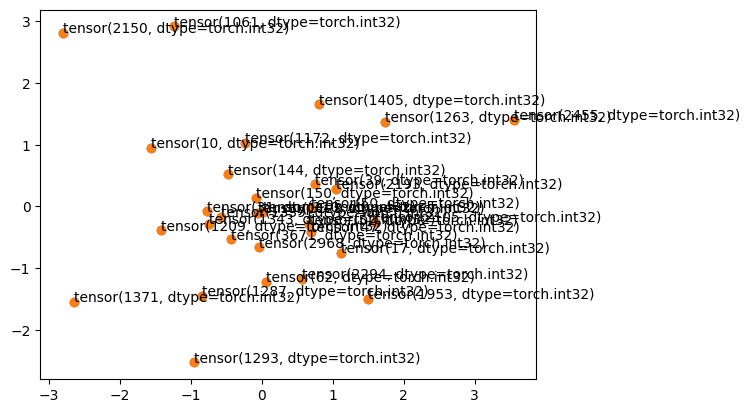

In [286]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(embeddings.detach().numpy())
pca_embeddings = pca.transform(embeddings.detach().numpy())

pca_embeddings

plt.scatter(pca_embeddings[:,0], pca_embeddings[:,1])

#labelling the embeddings
for i, txt in enumerate(movieIds[:]):
    plt.annotate(txt, (pca_embeddings[i,0], pca_embeddings[i,1]))

#plotting
plt.scatter(pca_embeddings[:,0], pca_embeddings[:,1])